# Deep Layout Parsing

In this tutorial, we will show how to use the `layoutparser` API to 

1. Load Deep Learning Layout Detection models and predict the layout of the paper image
2. Use the coordinate system to parse the output 

The `paper-image` is from https://arxiv.org/abs/2004.08686.

In [1]:
import layoutparser as lp
import cv2

In [6]:
from layoutparser.models import Detectron2LayoutModel, detectron2
import requests
import copy
import os


class ExtractLayout(Detectron2LayoutModel):

    def __init__(self,
                 config_path: str = 'lp://PubLayNet/faster_rcnn_R_50_FPN_3x/config',
                 *args,
                 **kwargs
                 ):
        """
        The following modified __init__ is to solve this issue:
                 https://github.com/Layout-Parser/layout-parser/issues/168

        :param config_path: A path to the config file
        """

        config_path_split = config_path.split('/')
        dataset_name = config_path_split[-3]
        model_name = config_path_split[-2]

        model_url = Detectron2LayoutModel.MODEL_CATALOG[dataset_name][model_name]
        config_url = detectron2.catalog.CONFIG_CATALOG[dataset_name][model_name]

        if 'model' not in os.listdir():
            os.mkdir('model')

        config_file_path, model_file_path = None, None

        for url in [model_url, config_url]:
            filename = url.split('/')[-1].split('?')[0]
            save_to_path = f"model/" + filename
            if 'config' in filename:
                config_file_path = copy.deepcopy(save_to_path)
            if 'model_final' in filename:
                model_file_path = copy.deepcopy(save_to_path)
            if filename in os.listdir("model"):
                continue
            r = requests.get(url, stream=True, headers={'user-agent': 'Wget/1.16 (linux-gnu)'})

            with open(save_to_path, "wb") as f:
                for chunk in r.iter_content(chunk_size=4096):
                    if chunk:
                        f.write(chunk)

        super().__init__(
            config_path=config_file_path,
            model_path=model_file_path,
            *args,
            **kwargs
        )


## Use Layout Models to detect complex layout 

`layoutparser` can identify the layout of the given document with only 4 lines of code.

In [2]:
image = cv2.imread("data/paper-image.jpg")
image = image[..., ::-1] 
    # Convert the image from BGR (cv2 default loading style)
    # to RGB

In [3]:
model = lp.Detectron2LayoutModel(
"./model/config.yml",
"./model/model_final.pth",
extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8], 
# faster_rcnn_R_50_FPN_3x
label_map={0: "Text", 1: "Title", 2: "List", 3: "Table", 4: "Figure"},
)
# modification based on
# https://github.com/Layout-Parser/layout-parser/issues/168

/Users/szymonkrawczyk/Documents/code/repos/OCRsandbox/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# using modified class
model = ExtractLayout(
    config_path='lp://PubLayNet/faster_rcnn_R_50_FPN_3x/config', 
    label_map={0: "Text", 1: "Title", 2: "List", 3: "Table", 4: "Figure"},
    extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.75]
)

In [ ]:
# model = lp.Detectron2LayoutModel('lp://PubLayNet/faster_rcnn_R_50_FPN_3x/config', 
#                                  extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8],
#                                  label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})
#     # Load the deep layout model from the layoutparser API 
#     # For all the supported model, please check the Model 
#     # Zoo Page: https://layout-parser.readthedocs.io/en/latest/notes/modelzoo.html

In [ ]:
# pip install -U 'git+https://github.com/nikhilweee/iopath'

In [12]:
layout = model.detect(image)
    # Detect the layout of the input image

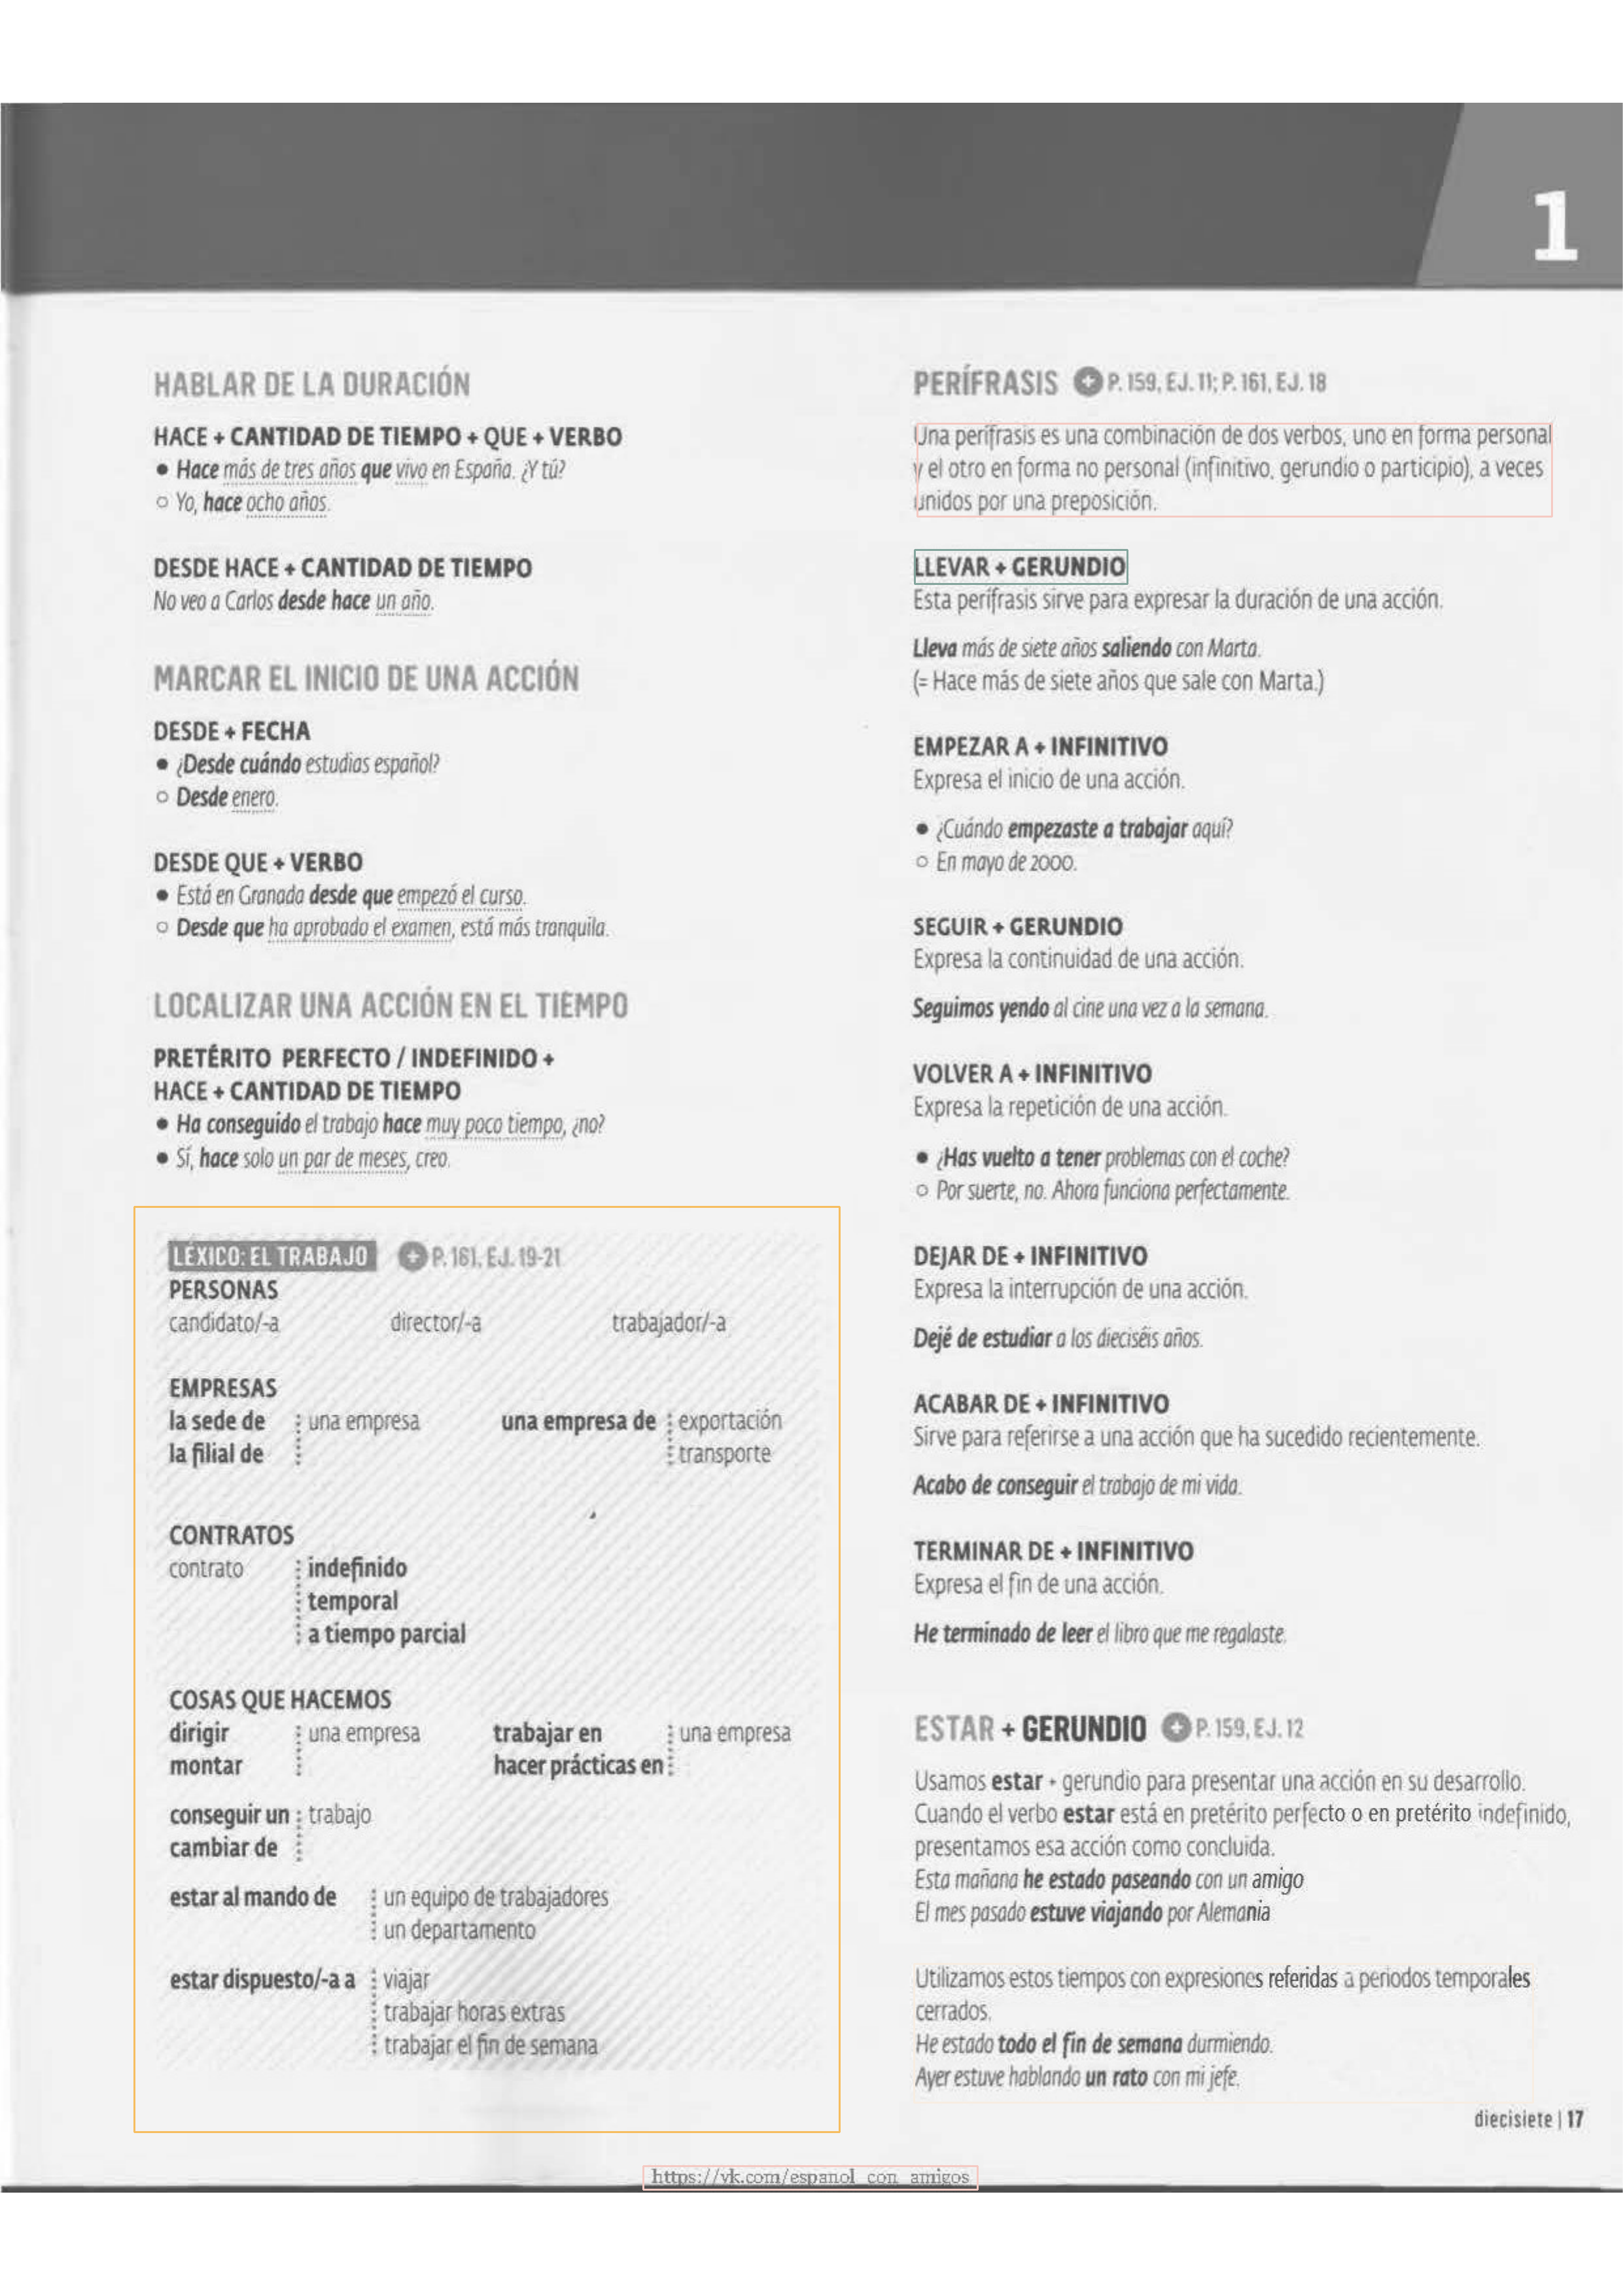

In [13]:
lp.draw_box(image, layout, box_width=3)
    # Show the detected layout of the input image

## Check the results from the model 

In [7]:
type(layout)         

layoutparser.elements.layout.Layout

The `layout` variable is a `Layout` instance, which is inherited from list and supports handy methods for layout processing.

In [36]:
layout[0]

TextBlock(block=Rectangle(x_1=205.30699157714844, y_1=1844.612060546875, x_2=1283.683349609375, y_2=3258.22509765625), text=None, id=None, type=Figure, parent=None, next=None, score=0.967104434967041)

`layout` contains a series of `TextBlock`s. They store the coordinates in the `.block` variable and other information of the blocks like block type in `.type`, text in `.text`, etc. More information can be found at the [documentation](https://layout-parser.readthedocs.io/en/latest/api_doc/elements.html#layoutparser.elements.TextBlock). 

## Use the coordinate system to process the detected layout

Firstly we filter text regions of specific type:

In [9]:
text_blocks = lp.Layout([b for b in layout if b.type=='Text'])
figure_blocks = lp.Layout([b for b in layout if b.type=='Figure'])

As you will see below, the text recognized as section 5.2 will be dropped
from our layout-recognized text regions as it is parsed as a TextBlock of
type 'Title' as indicated by its different colored bounding box in the image
above.

As there could be text regions detected inside the figure region, we just drop them:

In [10]:
text_blocks = lp.Layout([b for b in text_blocks \
                   if not any(b.is_in(b_fig) for b_fig in figure_blocks)])

Finally, sort the text regions and assign ids:

In [11]:
h, w = image.shape[:2]

left_interval = lp.Interval(0, w/2*1.05, axis='x').put_on_canvas(image)

left_blocks = text_blocks.filter_by(left_interval, center=True)
left_blocks.sort(key = lambda b:b.coordinates[1], inplace=True)
# The b.coordinates[1] corresponds to the y coordinate of the region
# sort based on that can simulate the top-to-bottom reading order 
right_blocks = lp.Layout([b for b in text_blocks if b not in left_blocks])
right_blocks.sort(key = lambda b:b.coordinates[1], inplace=True)

# And finally combine the two lists and add the index
text_blocks = lp.Layout([b.set(id = idx) for idx, b in enumerate(left_blocks + right_blocks)])

In [12]:
text_blocks.to_dataframe()


x_1          y_1          x_2          y_2 block_type  id  type  \
0  105.439056   671.718201  1137.593750   748.444214  rectangle   0  Text   
1  103.889389   766.864990   595.588501   968.831970  rectangle   1  Text   
2  104.672646  1032.218628   599.176575  1323.752441  rectangle   2  Text   
3  103.432686  1327.622192   601.058228  1429.960815  rectangle   3  Text   
4  108.640656  1448.555176   598.838562  1488.103760  rectangle   4  Text   
5  639.829529   772.914124  1135.684448  1044.628784  rectangle   5  Text   
6  638.754150  1075.359741  1137.243408  1154.616333  rectangle   6  Text   
7  646.418274  1420.171509  1132.868774  1479.722290  rectangle   7  Text   

      score  
0  0.995084  
1  0.996633  
2  0.998086  
3  0.995031  
4  0.995097  
5  0.997371  
6  0.964097  
7  0.999644

Visualize the cleaned text blocks:

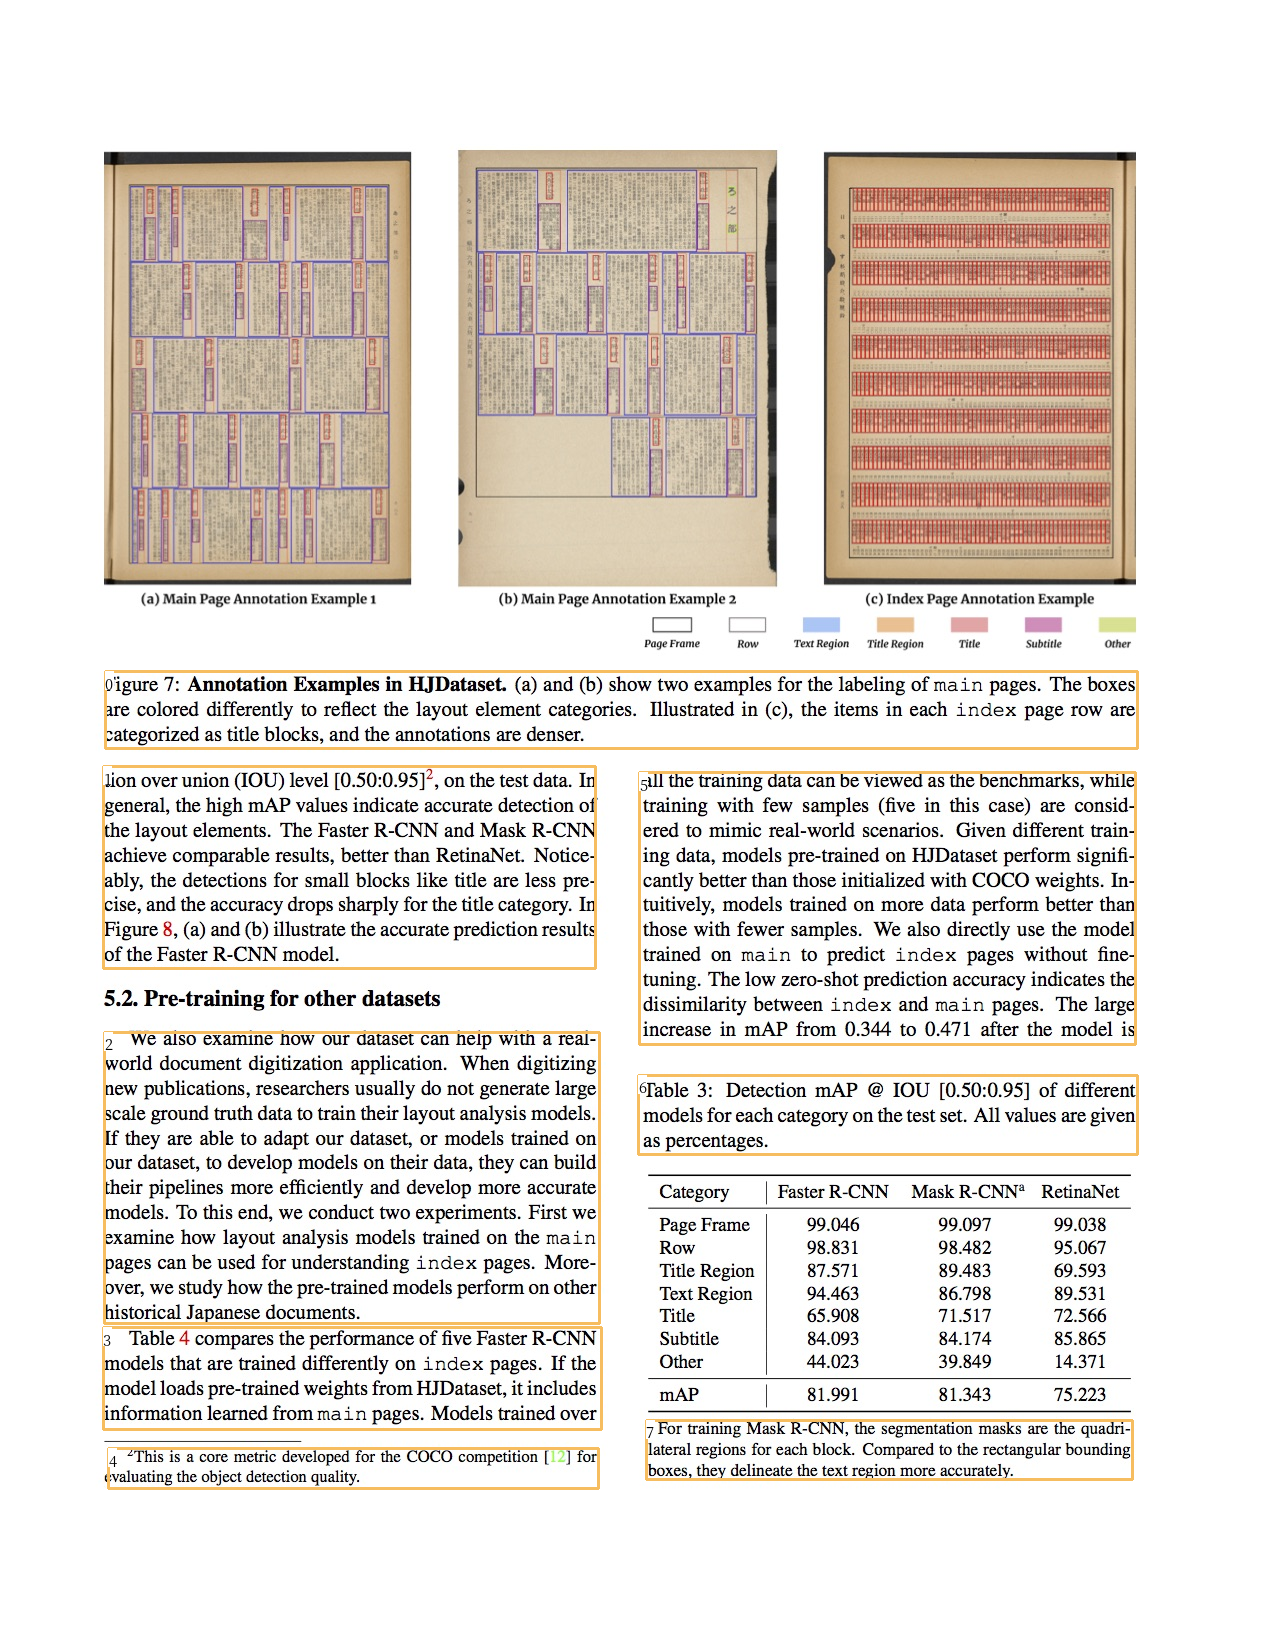

In [13]:
lp.draw_box(image, text_blocks,
            box_width=3, 
            show_element_id=True)

## Fetch the text inside each text region

We can also combine with the OCR functionality in `layoutparser` to fetch the text in the document. 

In [14]:
ocr_agent = lp.TesseractAgent(languages='eng') 
    # Initialize the tesseract ocr engine. You might need 
    # to install the OCR components in layoutparser:
    # pip install layoutparser[ocr]

In [15]:
for block in text_blocks:
    segment_image = (block
                       .pad(left=5, right=5, top=5, bottom=5)
                       .crop_image(image))
        # add padding in each image segment can help
        # improve robustness 
        
    text = ocr_agent.detect(segment_image)
    block.set(text=text, inplace=True)

In [16]:
for txt in text_blocks.get_texts():
    print(txt, end='\n---\n')

Figure 7: Annotation Examples in HJDataset. (a) and (b) show two examples for the labeling of main pages. The boxes
are colored differently to reflect the layout element categories. Illustrated in (c), the items in each index page row are
categorized as title blocks, and the annotations are denser.

---
tion over union (IOU) level [0.50:0.95]’, on the test data. In
general, the high mAP values indicate accurate detection of
the layout elements. The Faster R-CNN and Mask R-CNN
achieve comparable results, better than RetinaNet. Notice-
ably, the detections for small blocks like title are less pre-
cise, and the accuracy drops sharply for the title category. In
Figure 8, (a) and (b) illustrate the accurate prediction results
of the Faster R-CNN model.

---
We also examine how our dataset can help with
world document digitization application. When digitizing
new publications, researchers usually do not generate large
scale ground truth data to train their layout analysis models.
If they ar

In [10]:
# PDF
pdf_path = "data/zsel.pdf"
pdf = lp.io.load_pdf(pdf_path,load_images=True,dpi=300)


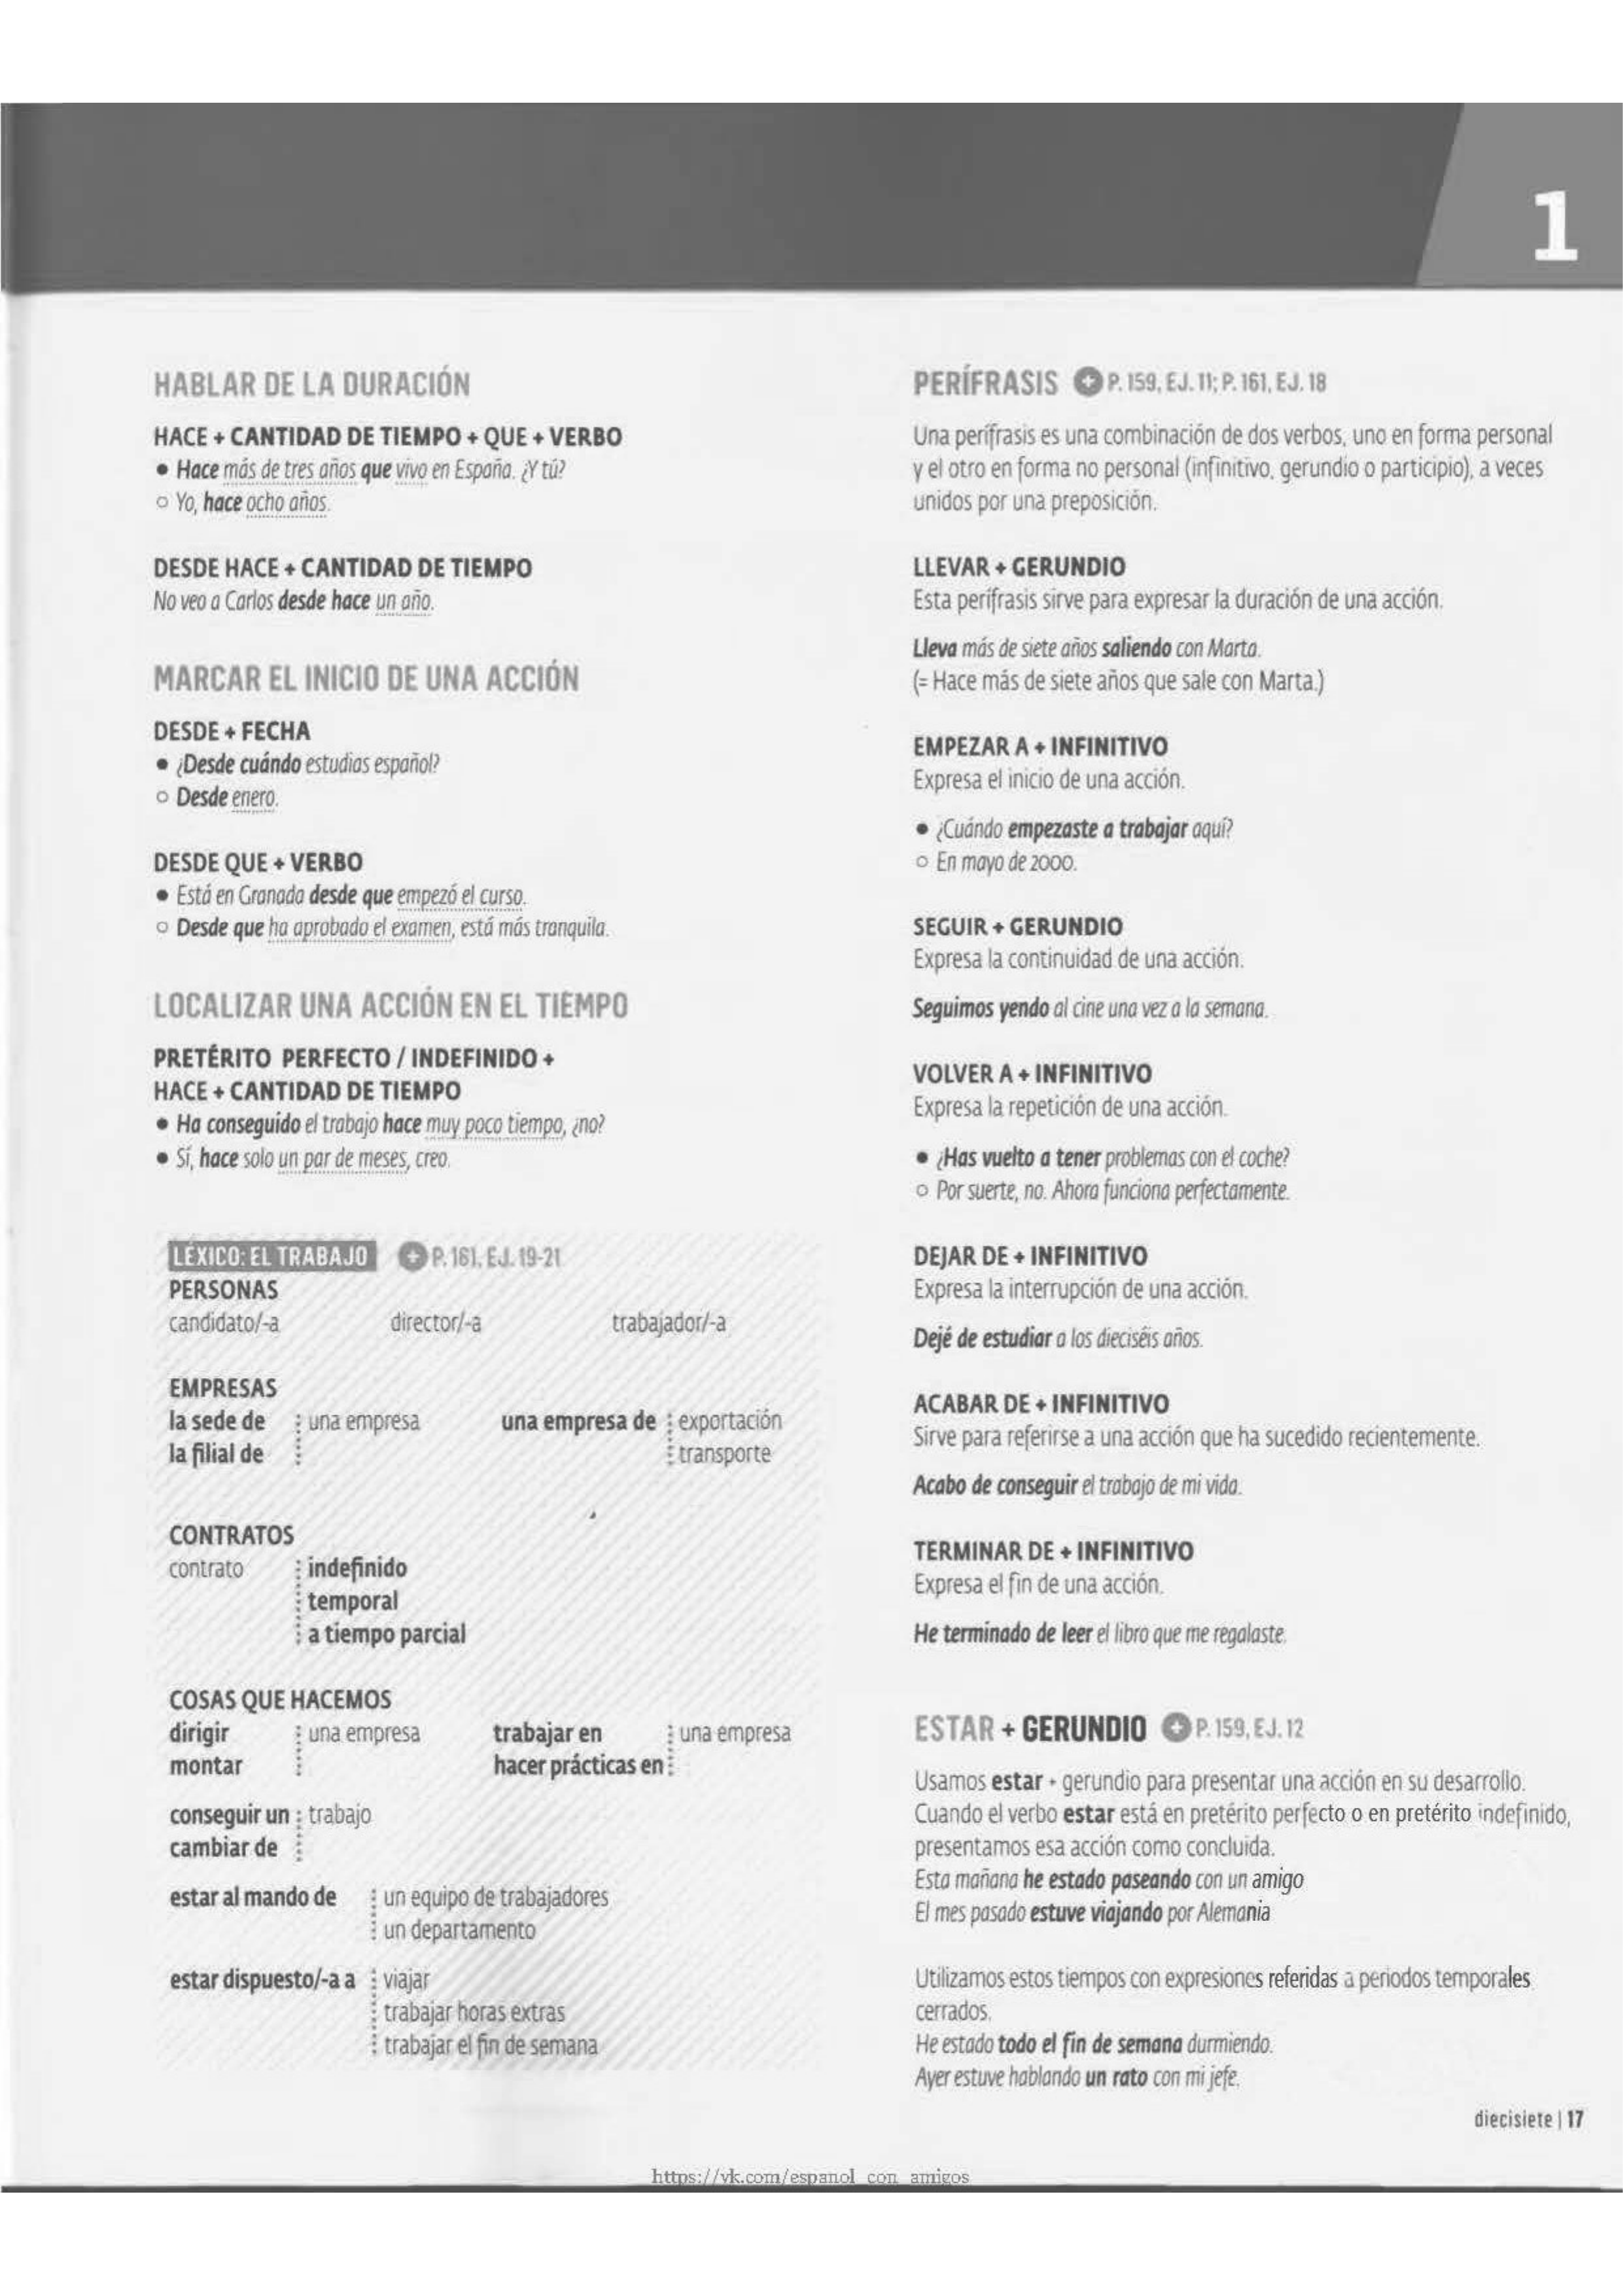

In [11]:
pdfimages=pdf[1]
image=pdfimages[0]
image